# GEVP analysis for the muon g-2

In [1]:
import sys
print(sys.executable)
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.linalg import eigh
from scipy.stats import f as fdist
from scipy.linalg import inv
user=os.environ['USER']
%autosave 60

/Users/thomasblum/Dropbox/python3.12/bin/python


Autosaving every 60 seconds


## Utils

In [2]:
def jackblocks(data,jacks,omit,prt=0):
    #loop over timeslices
    nconf=data.shape[0]
    nt=data.shape[1]
    norm=1.0/(nconf-1-len(omit))
    if(prt):print('omitting '+str(len(omit))+' of '+str(nconf)+' configs')
    for j in range(0,nt):
        #
        # sum over configs
        #
        sum=0.0
        for i in range(0,nconf):
            if i not in omit:
                sum = sum + data[i,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf):
            if i not in omit:
                jacks[n,j] = sum-data[i,j]
                jacks[n,j] *= norm
                n=n+1
# jackknife blocks of size bs>=1
def jackblocks_bs(data,bs=1):
    
    jacks=np.zeros([int(data.shape[0]/bs),data.shape[1]])
    nconf=data.shape[0]
    if nconf % bs:
        print("num confs not divisible by block size")
        return
    nt=data.shape[1]
    norm=1.0/(nconf-bs)
    # loop over timeslices
    for j in range(0,nt):
        #
        # sum over configs
        #
        sum=0.0
        for i in range(0,nconf):
            sum = sum + data[i,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf,bs):
            jacks[n,j] = sum
            for k in range(bs):
                jacks[n,j] -= data[i+k,j]
            jacks[n,j] *= norm
            n=n+1
            
    return jacks
#
# compute avg and jacknife error from a vector of jacknife blocks
def jack(vec):
    n=vec.shape[0]
    avg=0.0
    # compute average
    for i in range(0,n):
        avg+=vec[i]
    avg = avg/n
    # compute error
    err=0.0
    for i in range(0,n):
        err+=(vec[i]-avg)*(vec[i]-avg)
    err *= (n-1)/n
    err = np.sqrt(err)
    #print(f'{n} blocks, avg+-err= {avg:.4e} +- {err:.4e}')
    return avg, err


def covariance(data):
    
    nconf,tsize=data.shape
    covmat=np.zeros((tsize,tsize))
    avg = np.average(data,axis=0)
    for n in range(nconf):
        covmat+=np.outer(data[n]-avg,data[n]-avg)
    covmat*=1/nconf
    covmat *= nconf-1
    
    return avg,covmat

def const_plus_exp(t,*p):

    return p[0]+p[1]*np.exp(-t*p[2])

def err_const_plus_exp(t,p,c):
    
    fact = np.exp(-t*p[2])
    errsq  =   c[0][0]
    errsq +=   c[1][1]*(fact)**2
    errsq +=   c[2][2]*((-t)*p[1]*fact)**2
    errsq += 2*c[0][1]*fact
    errsq += 2*c[0][2]*(-t)*p[1]*fact
    errsq += 2*c[1][2]*(-t)*p[1]*fact**2
    
    return np.sqrt(errsq)

def fqed(qsq,m):
    
    return  m**2*qsq*Z(qsq,m)**3*(1-qsq*Z(qsq,m))/(1 + m**2*qsq*Z(qsq,m)**2)

def Z(qsq,m):
    
    return (np.sqrt(qsq**2+4*m**2*qsq)-qsq)/2/m**2/qsq

# long distance window filter
def Theta(t1,t2):
    
    return (1+np.tanh((t1-t2)/Delta))/2

class Ensemble_jks:
    
    def __init__(self):
        self.Op=0 # operator list
        self.jks=0 # gevp correlator single jackknife blocks
        self.jks_ct_all=0 # lvec-lvec correlator single jackknife blocks
        self.vec=0 # GEVP eigenvector double jackkife blocks
        self.e=0 # GEVP eigenvalue jackkife blocks
        self.amuOrig=0 # amu integrand for original correlator jackknife blocks
        self.amuRec=0 # amu integrand for reconstructed correlator jackknife blocks
        pass

## Global Input Parameters

In [3]:
alphaQED=1/137.035999074
fm = 1/0.1973269804
muon_mass=0.1056583755 # GeV
Delta=0.15

## Ensembles parameters

In [4]:
Ensemble='48I'
ainv=1.72
afm=1/fm/ainv
tv=8
numT=96
Zv=0.71097

### Operators

In [5]:
l48I=Ensemble_jks()

In [6]:
# these are the two pion and vector operators used in the GEVP
# svec corresponds to "smeared vector" operator and lvec to "local vector"
l48I.Op=['2pi.g5.0.0.1','2pi.g5.0.1.1','2pi.g5.1.1.1','2pi.g5.0.0.2','svec.gi','lvec.gi']

### Correlators

In [7]:
# This is the corresponding "matrix" correlation function (jackKnife blocks)
# for the above operators (fields)
l48I.jks=np.load('corrData/48Ijks.npy')
numDist=l48I.jks.shape[2]

### GEVP

In [16]:
# GEVP under jackknife
# implement the GEVP here, under a jackknife, i.e., do it for each jackknife block, so
# you can propagate the errors.
#
# You can use scipy's eigh. Note you have to pass it both C(t) and C(t0). Use t0=t-1
# Do the GEVP for the first 5 operators, i.e., leave out "lvec". You will use the latter later.
# Tip: I find it useful to "fold" (average) the correlators about the mid point in time
# here and in what follows

In [9]:
# do excited state fit under jackknife
# Here you will need to fit the GEVP energies from the above to get lambda_n + exp(-DeltaE t)
# to account for excited state contamination from the N+1 state omitted from the GEVP.
# the following fit ranges work well for each energy
#tmax=[16]*maxOp
#tmin=[5]*maxOp
#tmax[4]=13
# an initial guess for the fit parameters: guess = ([0.25,1.,1])
# To get the covariance matrix from the fit, you may use the function "covariance",
# defined in the Utils cell.
# Use scipy's curve_fit to do the fit and inv to compute the chi-square. 
# Optional: use fdist to compute the P-value:
#           F = fdist(dof,numDist-dof)
#           p_value = 1 - F.cdf(chi-square/dof/(numDist-1)*(numDist-dof))
# Again, do the fit under a jackknife

Make a plot of the energies over the time range in the fit
Include the data points and errors on the fit.

Here's mine
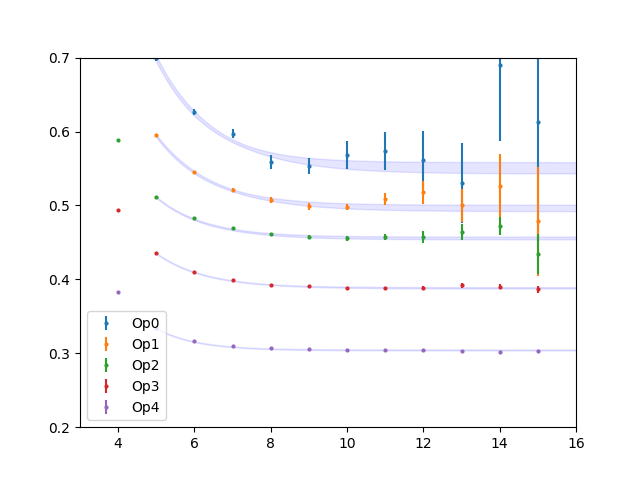

Compute the matrix elements of the "optimal" operators needed for the recontruction that project onto eigenstates of QCD ($\approx$ GEVP eigenvales). Use the GEVP eigenvectors and the correlators of the local current $V$ with the other operators. Try different time slices and verify your choice does not change the result ($i.e.$, the excited state contamination is negligible).

$|\langle 0 | O_V |n\rangle|^2=\frac{(v_{i,n} C_{V,i})^2}{v_{in}v_{j,n}C_{i,j}}$ (see Alpha collaboration paper https://iopscience.iop.org/article/10.1088/1126-6708/2009/04/094/pdf)

In [10]:
# construct optimal operators

In [11]:
# compare the reconstructed correlator to the original vector-vector correlator
# do it for 1,2,...,N states in the reconstruction and verify that for "large" t 
# the two agree.
# Choose your "best" GEVP time slice for this part

In [12]:
# the original correlation function on the same subset of configurations used in the GEVP
jks_ct=np.load('corrData/jks_ct.npy')
# The original on 386 configurations (use later)
l48I.jks_ct_all=np.load('corrData/jks_ct_all.npy')

My comparison:
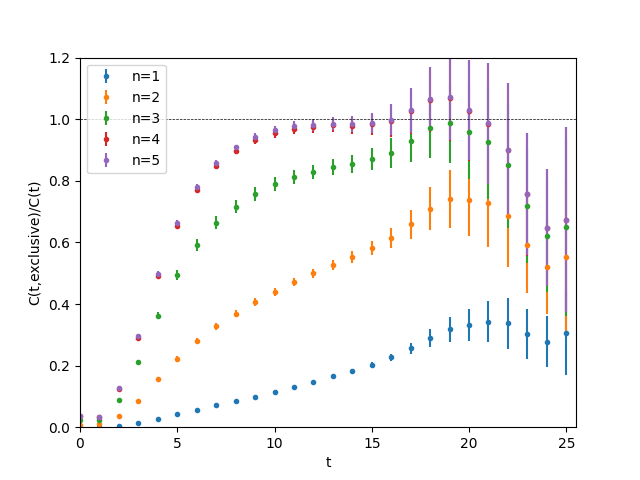

The rest of the excercise is just computing $a_\mu$ with the reconstructed correlator and using it for the long distance part

In [13]:
# this is useful to use both the original and then reconstructed for large t together
# in the analysis
SuperJackSize=l48I.jks_ct_all.shape[0]
gevpList=[1000,1080,1200,1280,1360,1440,1520,1600,1680,1760,1840,1960,2040,2160,1040,1160,1240,1320,1400,1480,1560,1640,1720,1800,1880,2000,2080]
print(len(gevpList))
print(SuperJackSize)

27
386


In [14]:
# this is the list of configurations for the original, so you can make a "super jackknife" set
# for the reconstructed correlator (see below)
corrList=[
640,
680,
720,
740,
760,
780,
800,
820,
840,
860,
880,
900,
920,
940,
960,
975,
985,
980,
990,
995,
1000,
1002,
1005,
1007,
1010,
1012,
1015,
1017,
1020,
1022,
1025,
1027,
1030,
1032,
1035,
1037,
1040,
1042,
1045,
1047,
1050,
1052,
1055,
1057,
1060,
1062,
1065,
1067,
1070,
1072,
1075,
1077,
1080,
1082,
1085,
1087,
1090,
1092,
1095,
1097,
1100,
1102,
1105,
1107,
1110,
1112,
1115,
1117,
1120,
1122,
1125,
1127,
1130,
1132,
1135,
1137,
1140,
1142,
1145,
1147,
1150,
1152,
1155,
1157,
1160,
1162,
1165,
1167,
1170,
1172,
1175,
1177,
1180,
1182,
1185,
1187,
1190,
1192,
1195,
1197,
1200,
1202,
1205,
1207,
1210,
1212,
1215,
1217,
1220,
1222,
1225,
1227,
1230,
1232,
1235,
1237,
1240,
1242,
1245,
1247,
1250,
1252,
1255,
1257,
1260,
1262,
1265,
1267,
1270,
1272,
1275,
1277,
1280,
1282,
1285,
1287,
1290,
1292,
1295,
1297,
1300,
1302,
1305,
1307,
1310,
1312,
1315,
1317,
1320,
1322,
1325,
1327,
1330,
1332,
1335,
1337,
1340,
1342,
1345,
1347,
1350,
1352,
1355,
1357,
1360,
1362,
1365,
1367,
1370,
1375,
1377,
1380,
1385,
1387,
1390,
1395,
1397,
1400,
1405,
1407,
1410,
1415,
1417,
1420,
1425,
1427,
1430,
1435,
1437,
1440,
1445,
1447,
1450,
1455,
1457,
1460,
1465,
1467,
1470,
1475,
1477,
1480,
1485,
1487,
1490,
1495,
1497,
1500,
1505,
1507,
1510,
1515,
1517,
1520,
1525,
1527,
1530,
1535,
1537,
1540,
1545,
1547,
1550,
1555,
1557,
1560,
1565,
1567,
1570,
1575,
1577,
1580,
1585,
1587,
1590,
1595,
1597,
1600,
1605,
1607,
1610,
1615,
1617,
1620,
1625,
1627,
1630,
1635,
1637,
1640,
1645,
1647,
1650,
1655,
1657,
1660,
1665,
1667,
1670,
1675,
1677,
1680,
1685,
1687,
1690,
1695,
1697,
1700,
1705,
1707,
1710,
1715,
1717,
1720,
1725,
1727,
1730,
1735,
1737,
1740,
1745,
1747,
1750,
1755,
1757,
1760,
1765,
1767,
1770,
1775,
1777,
1780,
1785,
1787,
1790,
1795,
1797,
1800,
1805,
1807,
1810,
1815,
1817,
1820,
1825,
1827,
1830,
1835,
1837,
1840,
1845,
1847,
1850,
1855,
1857,
1860,
1865,
1870,
1875,
1877,
1880,
1885,
1887,
1890,
1895,
1897,
1900,
1905,
1907,
1910,
1915,
1917,
1920,
1925,
1927,
1930,
1935,
1940,
1945,
1950,
1955,
1960,
1965,
1970,
1975,
1980,
1985,
1990,
1995,
2000,
2005,
2010,
2015,
2020,
2025,
2030,
2035,
2040,
2045,
2050,
2055,
2060,
2065,
2070,
2075,
2080,
2085,
2090,
2095,
2100,
2105,
2110,
2115,
2120,
2125,
2130,
2135,
2140,
2145,
2150,
2155,
2160,
2165,
2175,
2185,
2195]
print(len(corrList))

386


In [15]:
# Super jackknife set for the reconstructed correlator
l48I.recon_corr=np.zeros((SuperJackSize,NTfold+1,maxtv-mintv))
for tv in range(mintv,maxtv):
    ttv=tv-mintv
    recon_corr=np.zeros((numDist,NTfold+1))
    for t in range (NTfold+1):
        temp_corr=np.zeros(numDist)
        for j in range (numDist):
            for n in range(maxOp-1,-1,-1):
                temp_corr[j] += corr[j,tv,ttv,n] * np.exp(-fitpars[n,j,0]*t)
            recon_corr[j,t]=temp_corr[j]
    avg=np.average(recon_corr,axis=0)
    for j in range(SuperJackSize):
        l48I.recon_corr[j,:,ttv]=avg
    n=0
    for num in corrList:
        m=0
        for num2 in gevpList:
            if num==num2:
                l48I.recon_corr[n,:,ttv]=recon_corr[m]
            m+=1
        n+=1

NameError: name 'NTfold' is not defined

### LD part of $a_\mu$

In [ ]:
# compute amu for two light flavors with q=2/3, -1/3
# for all t using original C(t)
# and do superjack
l48I.amuRec=np.zeros(l48I.recon_corr.shape)
l48I.wt=np.zeros((SuperJackSize,l48I.recon_corr.shape[1]))
fact = 2*4*5/9*alphaQED**2*10**10
for t in range(NTfold+1):
    n=0
    for j in range(SuperJackSize):
        mmu=muon_mass/ainv
        # the QED kernel in euclidean time
        l48I.wt[j,t] = quad(lambda x: ((np.cos(np.sqrt(x)*t)-1)/x+0.5*t**2)*fqed(x,mmu), 0, np.inf)[0]
        l48I.amuRec[j,t]= l48I.recon_corr[j,t] * l48I.wt[j,t] * Theta(t*afm,1.0)
        l48I.amuRec[j,t] *= Zv**2
l48I.amuRec *= fact

In [ ]:
# compute amu for two light flavors with q=2/3, -1/3
# for all t using original C(t)
# and do superjack
l48I.amuOrig=np.zeros((SuperJackSize,l48I.jks_ct_all.shape[1]))
fact = 2*4*5/9*alphaQED**2*10**10
for t in range(NTfold+1):
    for j in range(SuperJackSize):
        mmu=muon_mass/ainv
        l48I.amuOrig[j,t]= l48I.jks_ct_all[j,t] * l48I.wt[j,t] * Theta(t*afm,1.0)
        l48I.amuOrig[j,t] *= Zv**2
l48I.amuOrig *= fact

my plot of the summand using the original and reconstructed correlators
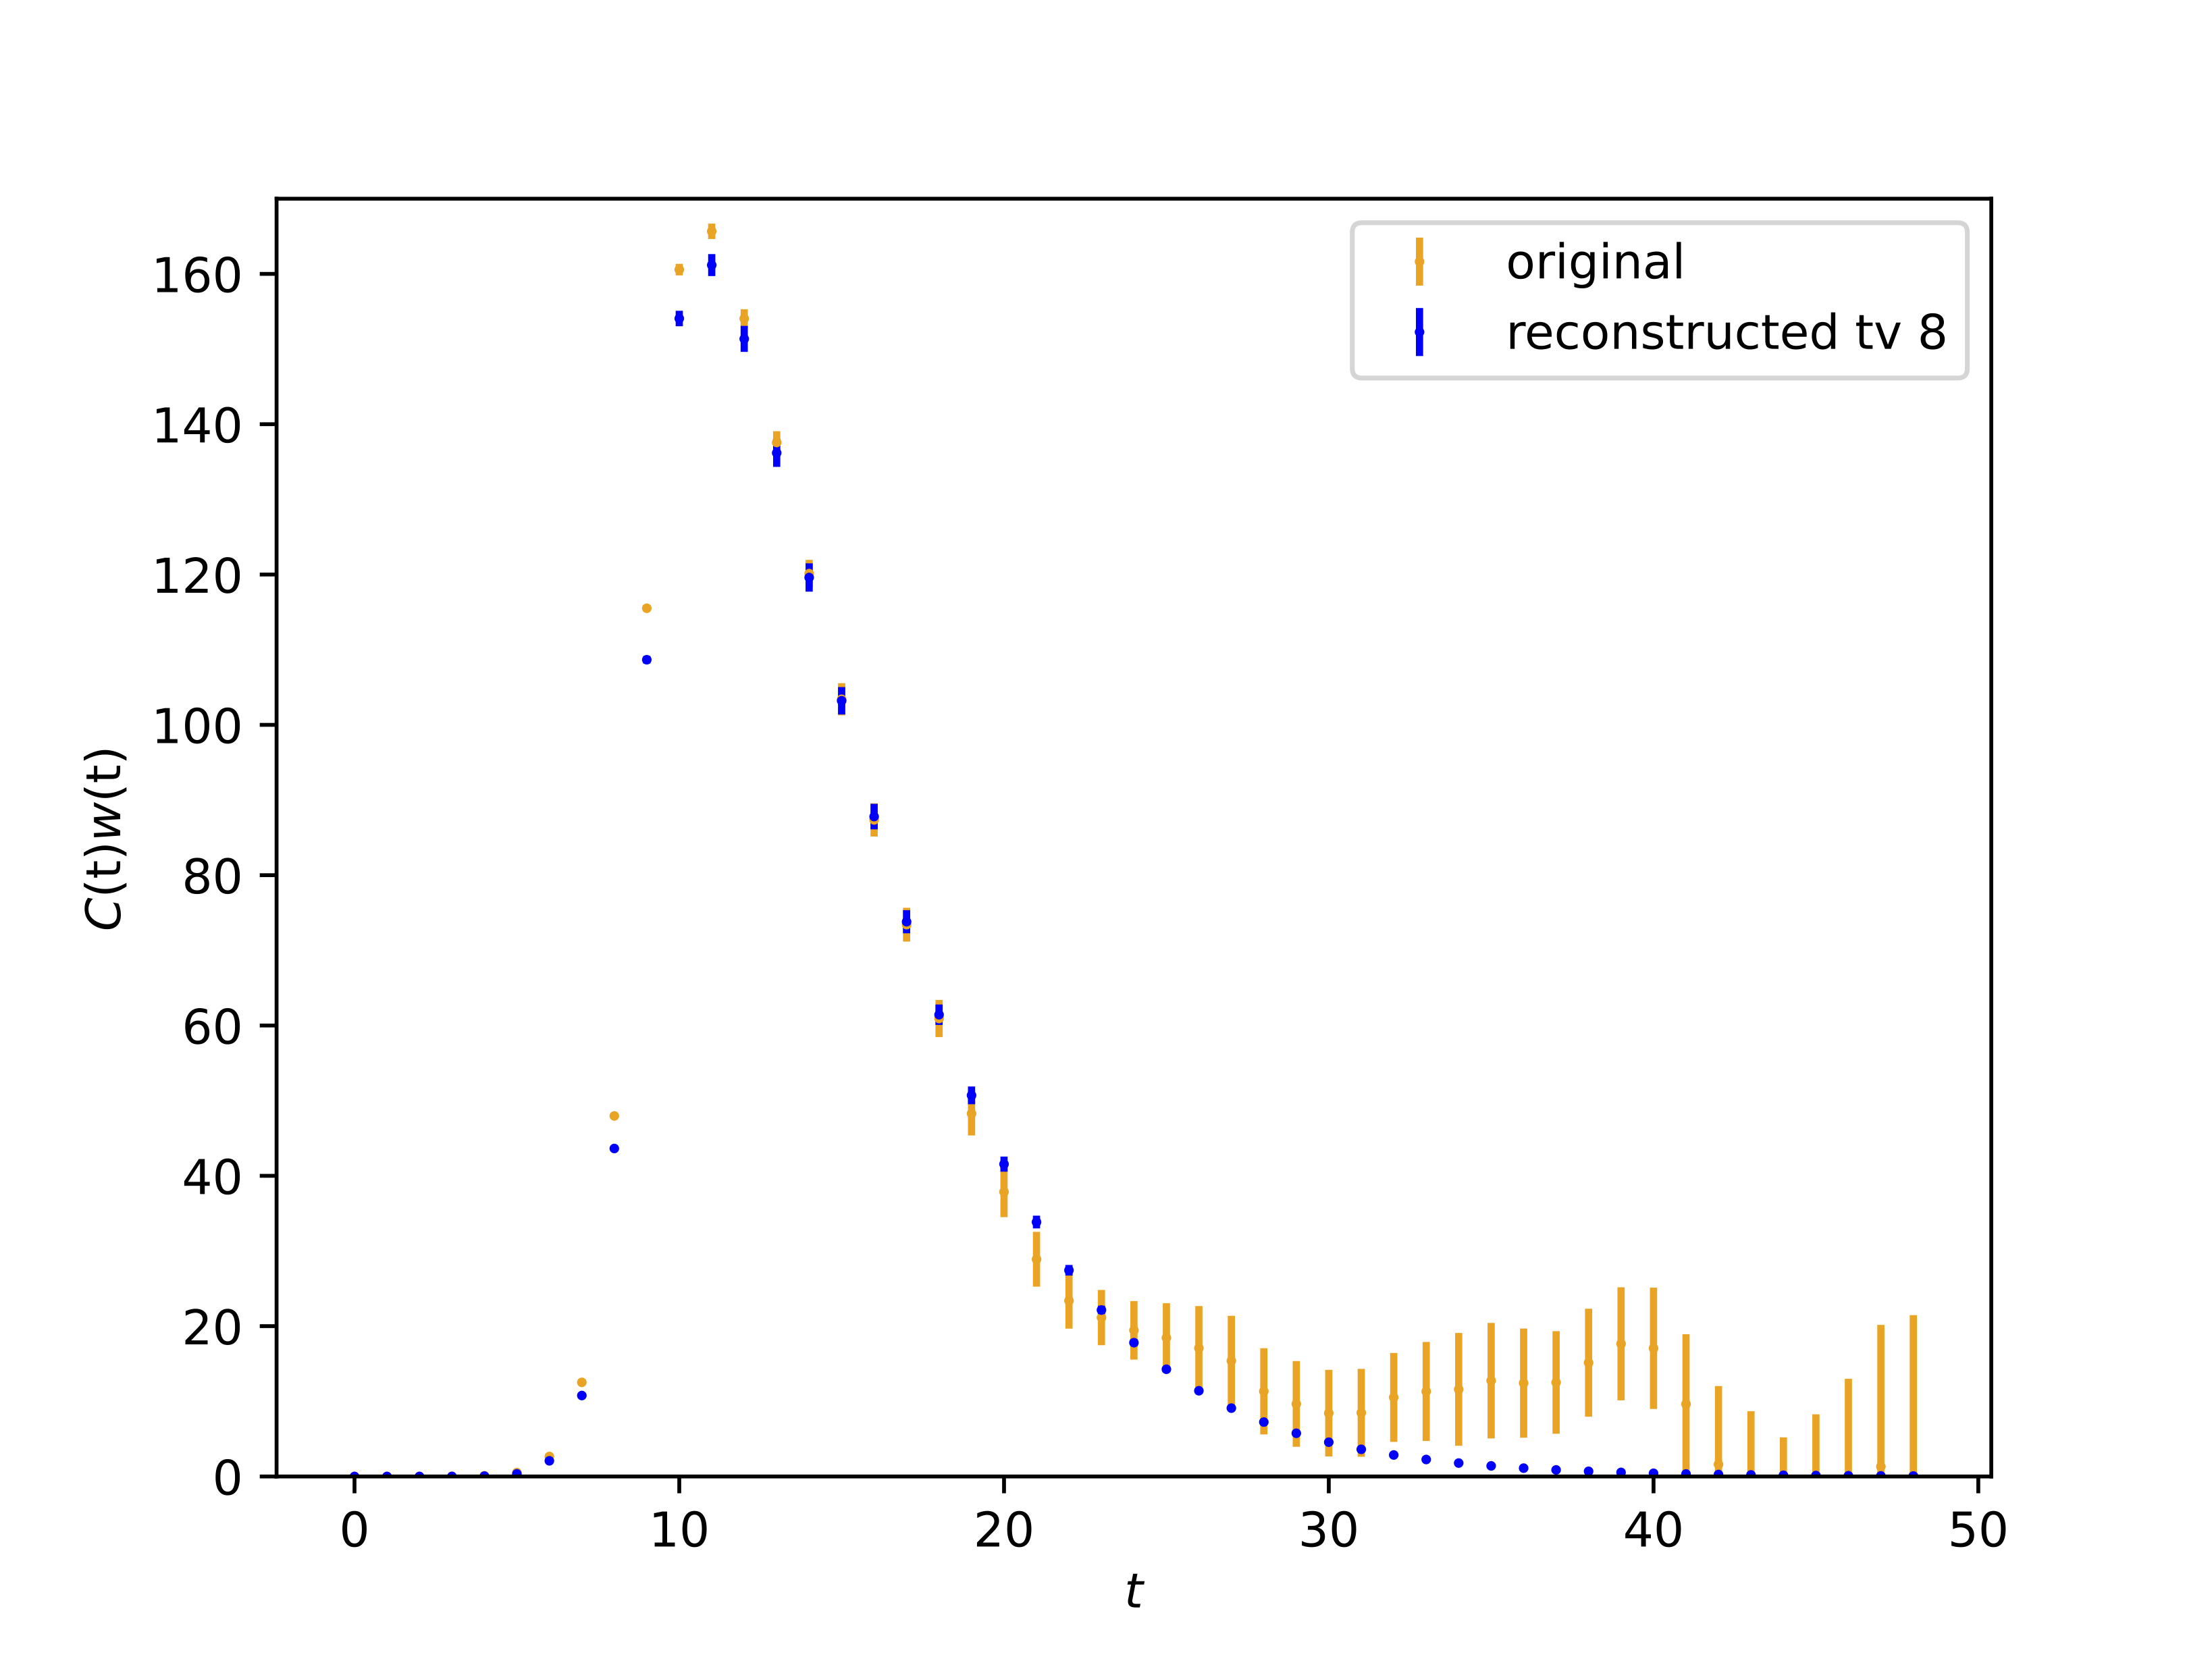